In [25]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import math
import time
import matplotlib.gridspec as gridspec

from astropy.io import ascii
from itertools import cycle
from itertools import permutations
from scipy.stats import skew

%matplotlib inline

# Plotting code

In [26]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """

    nColours = np.max(mappableList)+1
    uniqueMappableList = np.arange(nColours)
    
    zidx = np.array((mappableList))

    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= nColours: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,nColours):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [27]:
def makePlot(ax, xdata, ydata, colours, xlabel, ylabel, 
             linkSystems=False, sysIdxs=None,
             sizes=75, legendTitle=None,legendEntries=None, legendColours=None,
             xlim=[], ylim=[],xscale="linear",yscale="linear",alpha=1):
    ax.scatter(xdata,ydata,c=colours,s=sizes,alpha=alpha)
    #ax.hexbin(xdata,ydata,cmap='Blues')
    nonans = (np.isfinite(xdata) & np.isfinite(ydata))
    xdata=xdata[nonans]
    ydata=ydata[nonans]
    colours=colours[nonans]
    
    xmin = np.min(xdata)#.value
    xmax = np.max(xdata)#.value
    
    ymin = np.min(ydata)#.value
    ymax = np.max(ydata)#.value

    if not xlim:
        if xscale=="log":
            ax.set_xlim(0.1*xmin,10.*xmax)
        else:
            ax.set_xlim(0.95*xmin,1.05*xmax)
    else:
        ax.set_xlim(xlim)
        
    if not ylim:
        if yscale=="log":
            ax.set_ylim(0.1*ymin,10.*ymax)
        else:
            ax.set_ylim(0.95*ymin,1.05*ymax)
    else:
        ax.set_ylim(ylim)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    ax.set_xlabel(xlabel,fontsize=24)
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(labelsize=18)
    
    if legendEntries is not None:
        if xscale=="log":
            minx = 1.e-7*xmin
        else:
            minx = -1000+(-1000*xmin)
                
        if yscale=="log":
            miny = 1.e-7*ymin
        else:
            miny = -1000+(-1000*ymin)
            
        for i in range(0,len(legendEntries)):
            ax.scatter([minx,minx],[miny,miny],s=200,c=legendColours[i],edgecolors=legendColours[i],label='{0}'.format(legendEntries[i]))
        leg=ax.legend(loc=0,ncol=1,frameon=False,fontsize=15,title=legendTitle)
        leg.get_title().set_fontsize('22')
        
    if linkSystems is True:
        for i in np.unique(sysIdxs):
            if len(xdata[sysIdxs==i]) > 1:
                if "P" in xlabel:
                    psort = np.argsort(xdata[sysIdxs == i])
                    ax.plot(xdata[sysIdxs==i][psort],ydata[sysIdxs==i][psort],lw=0.5,marker='None',ls='-',color='k',alpha=alpha)
                elif "P" in ylabel:
                    psort = np.argsort(ydata[sysIdxs == i])
                    ax.plot(xdata[sysIdxs==i][psort],ydata[sysIdxs==i][psort],lw=0.5,marker='None',ls='-',color='k',alpha=alpha)
                else:
                    sort = np.argsort(xdata[sysIdxs == i])
                    ax.plot(xdata[sysIdxs==i][sort],ydata[sysIdxs==i][sort],lw=0.5,marker='None',ls='-',color='k',alpha=alpha)
                
            #else:
            #    ax.plot(xdata[sysIdxs==i],ydata[sysIdxs==i],lw=0.5,marker='o',ms=np.sqrt(sizes),mec='k',mfc='None',ls='None',color='k',alpha=alpha)
            
    return 

In [28]:
def getLossFromLogfile(filename):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    lastEpoch = content[-5].split("|")
    lastEpochCost = float(lastEpoch[2].split(" ")[2])
    return lastEpochCost

# Loop over different choices of num_classes

In [36]:
KOIs = ascii.read("../../../KOIs_chen2018_goodSystems.csv")

obs_features = np.vstack((np.log10(np.array(KOIs['koi_ror'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T
mod_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_sma'])).T,np.log10(np.array(KOIs['koi_insol'])).T,np.log10(np.array(KOIs['koi_srad'])).T,np.log10(np.array(KOIs['koi_smass'])).T)).T
final_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T



In [54]:
# stuff that's true regardless of num_classes
trainingDataFile = "./realPlanets_final/realKOIs_finalFeatures_70percent.txt"
CVDataFile = "./realPlanets_final/realKOIs_finalFeatures_30percent.txt"

# constraints based on stability
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
constraints = np.genfromtxt("./realPlanets_obs/realKOIs_targetConstraints.txt")
#print(np.shape(constraints))

n_planet_features = 2
n_stellar_features = 2
n_features = n_planet_features + n_stellar_features

# for predictions
n_samples = 100


features = final_features
mus = np.mean(features,axis=0)
sigmas = np.std(features,axis=0)


# obs
#labels = [r'$\log_{10}R_p/R_*$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
#lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
#scatterlims = [(-2.5,-1.),(-0.75,3.25),(4000,7000),(3.75,5.25)]

# mod
#labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}a$ [AU]',r'$\log_{10}S\ [S_\oplus]$',r'$\log_{10}R_*\ [R_\odot]$',r'$\log_{10}M_*\ [M_\odot]$']
#lims = [(-2,2),(-2,2),(-1.,1.),(-1.,1.),(-1.,1.)]
#scatterlims = [(-0.5,1.25),(-0.75,3),(-3,3),(-3,3),(-3,3)]

# final
labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
scatterlims = [(-0.5,1.25),(-0.75,3.25),(4000,7000),(3.75,5.25)]


classColoursList = ['#36747D','#F6AA1C','#7A1809','#003049','#BF3E0B',
                    '#064F40','#2E4D9F','#432371','#007F5F','#613DC1']


# Figure out which random seed 0,...,99 and which n_classes 2,...,15 had the optimal cost function.

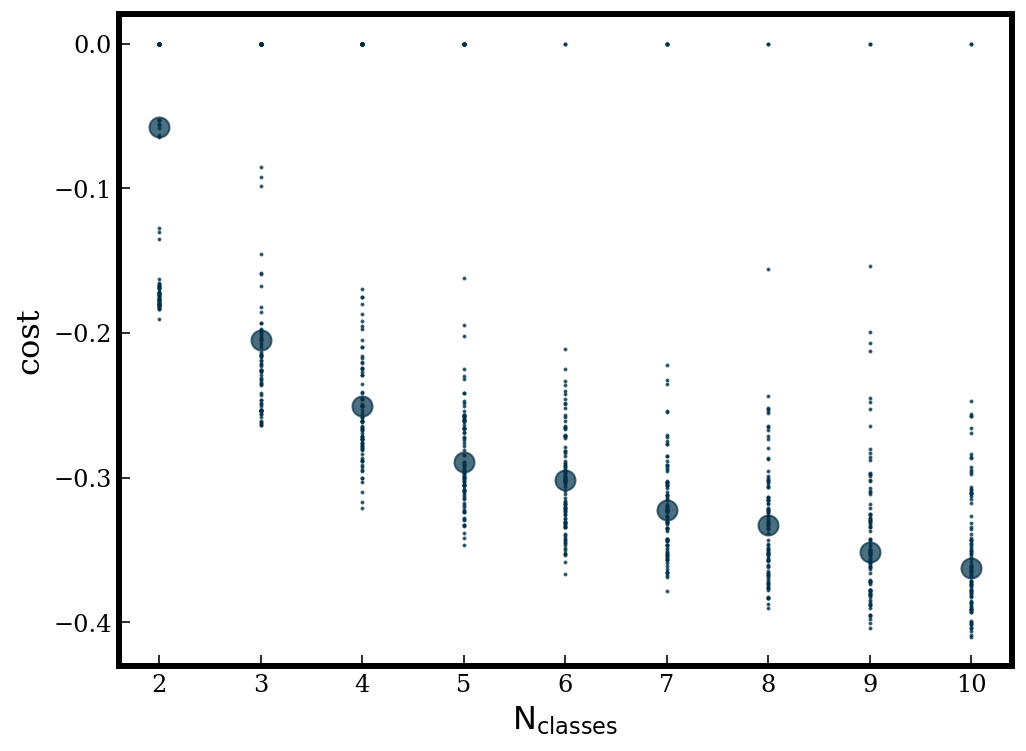

In [55]:
loss_arr = np.zeros((9,100))

for i, nc in enumerate(range(2,11)):
    for j, s in enumerate(range(0,100)):
        resultsFolder = "./realPlanets_final/{0}classes".format(nc)
        loss_arr[i,j] = getLossFromLogfile("{0}/realKOIs_finalFeatures_{1}classes_seed={2}.log".format(resultsFolder,nc,s))
"""
for i, nc in enumerate(range(2,11)):
    print(np.min(loss_arr[i]))
    fig = plt.figure(figsize=(4,3))
    plt.hist(loss_arr[i],range=(-0.5,0.),color='b',alpha=0.7)
    plt.title("n_classes = {0}".format(nc),fontsize=16)
    plt.show()"""

fig = plt.figure(figsize=(8,6))
for j in range(100):
    plt.plot(np.arange(2,11),loss_arr[:,j],color='#003049',marker='.',ls="None",ms=2,alpha=0.7)
plt.plot(np.arange(2,11),np.median(loss_arr,axis=1),color='#003049',marker='.',ls="None",ms=20,alpha=0.7)
plt.xlabel(r"$\mathrm{N}_{\mathrm{classes}}$",fontsize=16)
plt.ylabel("cost",fontsize=16)

plt.savefig("./realPlanets_final/cost_vs_nclasses.pdf",fmt="pdf",bbox_inches="tight")


In [56]:
print(np.min(loss_arr,axis=1))
print(np.argmin(loss_arr,axis=1))

[-0.19024251 -0.26377191 -0.32074003 -0.34663782 -0.36662194 -0.37854722
 -0.38994153 -0.40364703 -0.40976867]
[96 61 58 87 82 27 60 98  7]


In [16]:
# classification plots for training data first
classes = np.arange(2,11)
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)

for n_idx in np.arange(len(classes)):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_{1}classes.log".format(resultsFolder,n_classes)

    # get training data
    with open(trainingDataFile, "rb") as picklefile:
        trainingSystems = pickle.load(picklefile)

    data = np.zeros((1,n_features+1))

    for i in range(len(trainingSystems)):
        sys = trainingSystems[i]
        for j in range(1,len(sys)):
            row = np.zeros_like(data[0])
            row[:-1] = np.array(sys[j])
            row[-1] = i
            data = np.vstack((data,row))
    data = data[1:]
    #print(data)
    #print(np.shape(data))

    mults = np.zeros_like(data[:,0])
    for i in range(len(data)):
        thisSystemMask = (data[:,-1] == data[i,-1])
        mults[i] = int(len(data[thisSystemMask]))
    
    data = np.hstack((data,np.atleast_2d(mults).T))
    
    losses = np.load("{0}/realKOIs_finalFeatures_70percent_losses_{1}.npy".format(resultsFolder,seed))
    results = np.load("{0}/realKOIs_finalFeatures_70percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    results_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_70percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    idxs = np.load("{0}/realKOIs_finalFeatures_70percent_idxs_{1}.npy".format(resultsFolder,seed))

    data = data[idxs]

    bestClass = np.argmax(results,axis=1)
    bestClass_fromContext = np.argmax(results_fromContext,axis=1)
    
    # TRUTHS and RESULTS
    arrays_ = [bestClass,bestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in np.sort(np.unique(mults)):
        print("mult is {0}".format(m))
        data_toplot = data[data[:,-1] == m]
        #print(np.shape(data_toplot))
        arrays_ = [bestClass[data[:,-1]==m],bestClass_fromContext[data[:,-1]==m]]
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

            fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
            gs = gridspec.GridSpec(n_planet_features, n_planet_features)

            for i in range(n_planet_features):
                for j in range(n_planet_features):
                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        makePlot(ax,
                                xdata=((data_toplot[:,j]*sigmas[j])+mus[j]),#+arrays_[h]/3.,
                                ydata=((data_toplot[:,i]*sigmas[i])+mus[i]),
                                linkSystems=True,
                                sysIdxs=data_toplot[:,-2].astype(int),
                                colours=class_colours,
                                xlim=scatterlims[j],#scaledLimits[j],
                                ylim=scatterlims[i],#scaledLimits[i],
                                #legendTitle="{0}\nclass\nindex".format(titles_[h]),
                                #legendEntries=np.array(class_legendEntries).astype(int),
                                #legendColours=class_legendColours,
                                #xscale="log",
                                #yscale="log",
                                xlabel=labels[j],
                                ylabel=labels[i],
                                alpha=0.25)

                    if i==j:
                        ax = plt.subplot(gs[i,j])
                        toHist = []
                        nmax = 0
                        for k in np.unique(arrays_[h]).astype(int):
                            #toHist.append(data[:,i][arrays_[h]==k])
                            try:
                                #n,bins,patches=ax.hist(data[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((data_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==k],bins=100,color=class_legendColours[k],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)
                            except IndexError:
                                #n,bins,patches=ax.hist(data[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((data_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)

                        #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                        #nmax = np.max(n)
                        ax.set_xlabel(labels[i],fontsize=24)
                        ax.tick_params(labelsize=18)
                        ax.set_xlim(scatterlims[i])
                        ax.set_ylim(0,nmax*1.1)


            plt.subplots_adjust(wspace=0.2,hspace=0.2)
            #plt.show()

            plt.savefig("{0}/realKOIs_finalFeatures_70percent_{1}classes_{2}_{3}_mult={4}_planetFeaturesOnly.png".format(resultsFolder,n_classes,plotTitles_[h],seed,m),fmt="png")
            plt.close()

n_classes is 2
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
n_classes is 3
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
n_classes is 4
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
n_classes is 5
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
n_classes is 6
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
n_classes is 7
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
n_classes is 8
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
n_classes is 9
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
n_classes is 10
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0


In [59]:
classes = np.arange(2,11)
#classes = np.atleast_1d(np.array((5)))
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)
#seeds = np.atleast_1d(np.array((87)))
print(seeds)

#optimalLosses = []
#nDisagrees = []

predMSE = np.zeros((n_features,6,len(classes)))
print(np.shape(predMSE))
randomMSE = np.zeros((n_features,6,len(classes)))

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

    CVdata = np.zeros((1,n_features+1))
    CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        # organize constraints in the same order
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
    CVdata = CVdata[1:]
    CVconstraints = CVconstraints[1:]
    #print(CVconstraints)
    #print(len(CVdata))
    #print(np.shape(CVdata))
    #print(np.shape(CVconstraints))
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    
    losses = np.load("{0}/realKOIs_finalFeatures_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)

    
    # Do not plot single-planet systems!!
    #CVbestClass_nosingles = CVbestClass[CVdata[:,-1] > 1]
    #CVbestClass_fromContext_nosingles = CVbestClass_fromContext[CVdata[:,-1] > 1]
    #CVdata_nosingles = CVdata[CVdata[:,-1] > 1]
    
    #nDisagree = len(np.arange(len(CVbestClass))[CVbestClass != CVbestClass_fromContext])
    #nDisagrees.append(nDisagree)
    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in np.sort(np.unique(mults)):
        print("mult is {0}".format(m))
        CVdata_toplot = CVdata[CVdata[:,-1] == m]
        arrays_ = [CVbestClass[CVdata[:,-1]==m],CVbestClass_fromContext[CVdata[:,-1]==m]]
        
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

            fig = plt.figure(figsize=(7*n_planet_features,7*(n_planet_features)))
            gs = gridspec.GridSpec((n_planet_features), (n_planet_features))

            for i in range(n_planet_features):
                for j in range(n_planet_features):
                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        makePlot(ax,
                                xdata=((CVdata_toplot[:,j]*sigmas[j])+mus[j]),#+arrays_[h]/3.,
                                ydata=((CVdata_toplot[:,i]*sigmas[i])+mus[i]),
                                linkSystems=True,
                                sysIdxs=CVdata_toplot[:,-2].astype(int),
                                colours=class_colours,
                                xlim=scatterlims[j],#scaledLimits[j],
                                ylim=scatterlims[i],#scaledLimits[i],
                                #legendTitle="{0}\nclass\nindex".format(titles_[h]),
                                #legendEntries=np.array(class_legendEntries).astype(int),
                                #legendColours=class_legendColours,
                                #xscale="log",
                                #yscale="log",
                                xlabel=labels[j],
                                ylabel=labels[i],
                                alpha=0.25)
                    '''
                    if i==j:
                        ax = plt.subplot(gs[i,j])
                        toHist = []
                        nmax = 0
                        for k in np.unique(arrays_[h]).astype(int):
                            #toHist.append(CVdata[:,i][arrays_[h]==k])
                            try:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==k],bins=100,color=class_legendColours[k],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)
                            except IndexError:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)

                        #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                        #nmax = np.max(n)
                        ax.set_xlabel(labels[i],fontsize=24)
                        ax.tick_params(labelsize=18)
                        ax.set_xlim(scatterlims[i])
                        ax.set_ylim(0,nmax*1.1)

                        '''
            plt.subplots_adjust(wspace=0.2,hspace=0.2)
            #plt.show()

            plt.savefig("{0}/realKOIs_finalFeatures_30percent_{1}classes_{2}_{3}_mult={4}_planetFeaturesOnly_noHist.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed,m),fmt="pdf",bbox_inches="tight")
            #plt.savefig("{0}/realKOIs_finalFeatures_{1}classes_{2}_{3}_mult={4}_planetFeaturesOnly.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed,m),fmt="pdf",bbox_inches="tight")
            
            plt.close()
    
    

[96 61 58 87 82 27 60 98  7]
(4, 6, 9)
n_classes is 2
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 3
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 4
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 5
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 6
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 7
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 8
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 9
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 10
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0


# all multiplicities on the same plot

In [60]:
classes = np.arange(2,11)
#classes = np.atleast_1d(np.array((5)))
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)
#seeds = np.atleast_1d(np.array((87)))
print(seeds)

#optimalLosses = []
#nDisagrees = []

predMSE = np.zeros((n_features,6,len(classes)))
print(np.shape(predMSE))
randomMSE = np.zeros((n_features,6,len(classes)))

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

    CVdata = np.zeros((1,n_features+1))
    CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        # organize constraints in the same order
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
    CVdata = CVdata[1:]
    CVconstraints = CVconstraints[1:]
    #print(CVconstraints)
    #print(len(CVdata))
    #print(np.shape(CVdata))
    #print(np.shape(CVconstraints))
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    
    losses = np.load("{0}/realKOIs_finalFeatures_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)

    
    # Do not plot single-planet systems!!
    #CVbestClass_nosingles = CVbestClass[CVdata[:,-1] > 1]
    #CVbestClass_fromContext_nosingles = CVbestClass_fromContext[CVdata[:,-1] > 1]
    #CVdata_nosingles = CVdata[CVdata[:,-1] > 1]
    
    #nDisagree = len(np.arange(len(CVbestClass))[CVbestClass != CVbestClass_fromContext])
    #nDisagrees.append(nDisagree)
    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in range(1):
        CVdata_toplot = CVdata
        arrays_ = [CVbestClass,CVbestClass_fromContext]
        
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

            fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
            gs = gridspec.GridSpec(n_planet_features, n_planet_features)

            for i in range(n_planet_features):
                for j in range(n_planet_features):
                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        makePlot(ax,
                                xdata=((CVdata_toplot[:,j]*sigmas[j])+mus[j]),#+arrays_[h]/3.,
                                ydata=((CVdata_toplot[:,i]*sigmas[i])+mus[i]),
                                linkSystems=False,
                                sysIdxs=CVdata_toplot[:,-2].astype(int),
                                colours=class_colours,
                                xlim=scatterlims[j],#scaledLimits[j],
                                ylim=scatterlims[i],#scaledLimits[i],
                                #legendTitle="{0}\nclass\nindex".format(titles_[h]),
                                #legendEntries=np.array(class_legendEntries).astype(int),
                                #legendColours=class_legendColours,
                                #xscale="log",
                                #yscale="log",
                                xlabel=labels[j],
                                ylabel=labels[i],
                                alpha=0.25)
                    '''
                    if i==j:
                        ax = plt.subplot(gs[i,j])
                        toHist = []
                        nmax = 0
                        for k in np.unique(arrays_[h]).astype(int):
                            #toHist.append(CVdata[:,i][arrays_[h]==k])
                            try:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==k],bins=100,color=class_legendColours[k],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)
                            except IndexError:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)

                        #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                        #nmax = np.max(n)
                        ax.set_xlabel(labels[i],fontsize=24)
                        ax.tick_params(labelsize=18)
                        ax.set_xlim(scatterlims[i])
                        ax.set_ylim(0,nmax*1.1)
                        '''

            plt.subplots_adjust(wspace=0.2,hspace=0.2)
            #plt.show()

            plt.savefig("{0}/realKOIs_finalFeatures_30percent_{1}classes_{2}_{3}_allmult_planetFeaturesOnly_noHist.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed),fmt="pdf",bbox_inches="tight")

            
            plt.close()
    
   

[96 61 58 87 82 27 60 98  7]
(4, 6, 9)
n_classes is 2
n_classes is 3
n_classes is 4
n_classes is 5
n_classes is 6
n_classes is 7
n_classes is 8
n_classes is 9
n_classes is 10


In [18]:
633 + 204 + 120 + 64 + 20 + 12

1053